In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:

team = pd.read_csv('game_teams_stats.csv')


goalie = pd.read_csv('game_goalie_stats.csv')


skater = pd.read_csv('game_skater_stats.csv')

In [5]:
team.dtypes

game_id                     int64
team_id                     int64
HoA                        object
won                          bool
settled_in                 object
head_coach                 object
goals                     float64
shots                     float64
hits                      float64
pim                       float64
powerPlayOpportunities    float64
powerPlayGoals            float64
faceOffWinPercentage      float64
giveaways                 float64
takeaways                 float64
blocked                   float64
startRinkSide              object
dtype: object

In [6]:
team.nunique()

game_id                   23735
team_id                      37
HoA                           2
won                           2
settled_in                    3
head_coach                  146
goals                        13
shots                        60
hits                         77
pim                         110
powerPlayOpportunities       17
powerPlayGoals                8
faceOffWinPercentage        428
giveaways                    51
takeaways                    36
blocked                      44
startRinkSide                 2
dtype: int64

In [7]:
print('HoA unique values: ') 
print(team['HoA'].value_counts())
print('won unique values: ') 
print(team['won'].value_counts())
print('settled_in unique values: ') 
print(team['settled_in'].value_counts())
print('startRinkSide unique values: ') 
print(team['startRinkSide'].value_counts())

HoA unique values: 
away    26305
home    26305
Name: HoA, dtype: int64
won unique values: 
False    26947
True     25663
Name: won, dtype: int64
settled_in unique values: 
REG    40306
OT     12256
tbc       48
Name: settled_in, dtype: int64
startRinkSide unique values: 
left     26852
right    23366
Name: startRinkSide, dtype: int64


In [8]:
# replace catagorical features with dummy variables
team['home'] = np.where(team['HoA']=='home',True,False).astype(int)
team['away'] = np.where(team['HoA']=='away',True,False).astype(int)
team['start_on_left'] = np.where(team['startRinkSide']=='left',True,False).astype(int)
team['start_on_right'] = np.where(team['startRinkSide']=='right',True,False).astype(int)
team['overtime_required'] = np.where(team['settled_in']=='OT',True,False).astype(int)
team['regulation'] = np.where(team['settled_in']=='REG',True,False).astype(int)
team['overtime_tbc'] = np.where(team['settled_in']=='tbc',True,False).astype(int)
team.drop(team[team.overtime_tbc == 1].index, inplace=True)

team.drop(columns=['HoA','settled_in','startRinkSide','head_coach','overtime_tbc'],inplace=True)

team = team.add_prefix('team_')
team.rename(columns={'team_game_id':'game_id','team_team_id':'team_id'},inplace=True)

In [9]:
goalie.describe(include='all')

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
count,5.665600e+04,5.665600e+04,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,56656.000000,52554,56517.000000,51913.000000,56459.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26277,NaN,NaN,NaN
mean,2.010748e+09,8.468184e+06,16.902146,3369.154564,0.021075,0.000159,0.085851,27.684235,25.203562,4.078032,0.776529,20.342965,0.850925,22.133313,4.693589,NaN,90.112653,84.258532,91.039223
std,6.068775e+06,7.417587e+03,11.235659,734.192491,0.145223,0.012603,0.610103,8.825602,8.650819,3.201827,1.046156,7.577797,1.105461,7.757074,3.435020,NaN,7.798010,22.668988,8.253391
min,2.000020e+09,8.445275e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,2.006020e+09,8.462055e+06,8.000000,3525.000000,0.000000,0.000000,0.000000,23.000000,20.000000,2.000000,0.000000,16.000000,0.000000,17.000000,2.000000,NaN,87.096774,75.000000,87.500000
50%,2.011021e+09,8.470320e+06,16.000000,3598.000000,0.000000,0.000000,0.000000,28.000000,26.000000,4.000000,0.000000,21.000000,1.000000,22.000000,4.000000,NaN,91.428571,92.857143,92.307692
75%,2.016021e+09,8.473607e+06,24.000000,3600.000000,0.000000,0.000000,0.000000,33.000000,31.000000,6.000000,1.000000,25.000000,1.000000,27.000000,7.000000,NaN,95.000000,100.000000,96.153846


In [10]:
goalie['goalies_used'] = 1
goalie.drop(columns=['decision'],inplace=True)


goalie.drop(goalie[goalie.shortHandedSaves<0].index, inplace=True)


goalie = goalie.groupby(by=['game_id', 'team_id']).sum()


goalie['save_percentage'] = goalie['saves'] / goalie['shots']
goalie['power_play_save_percentage'] = goalie['powerPlaySaves'] / goalie['powerPlayShotsAgainst']
goalie['even_strength_save_percentage'] = goalie['evenSaves'] / goalie['evenShotsAgainst']
goalie['time_on_ice'] = goalie['timeOnIce'] / goalie['goalies_used']
goalie.drop(columns=['player_id','timeOnIce','savePercentage', \
                     'powerPlaySavePercentage','evenStrengthSavePercentage'], inplace = True)


goalie = goalie.add_prefix('goalie_')
goalie.rename(columns={'goalie_game_id':'game_id','goalie_team_id':'team_id'},inplace=True)

In [11]:
skater.describe(include='all')

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
count,9.458300e+05,9.458300e+05,945830.000000,945830.000000,945830.000000,945830.000000,945830.000000,547723.000000,945830.000000,945830.000000,...,945830.000000,547723.000000,547723.000000,945830.000000,945830.000000,547723.000000,945830.000000,945830.000000,945830.000000,945830.000000
mean,2.010763e+09,8.469436e+06,16.862985,988.705195,0.262792,0.154644,1.664201,1.304696,0.037124,0.070543,...,3.345550,0.391313,0.475580,0.004924,0.005195,0.798327,-0.007727,807.715360,80.117924,100.871911
std,6.072766e+06,7.299758e+03,11.146468,310.968101,0.533979,0.408620,1.547529,1.462937,0.196857,0.276856,...,6.176884,0.671742,0.765434,0.070568,0.072288,1.095038,1.094068,245.388009,95.408978,118.131458
min,2.000020e+09,8.444894e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000
25%,2.006020e+09,8.466181e+06,8.000000,787.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,650.000000,0.000000,0.000000
50%,2.011021e+09,8.470626e+06,16.000000,999.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,809.000000,47.000000,60.000000
75%,2.016030e+09,8.475169e+06,24.000000,1198.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,968.000000,133.000000,169.000000
max,2.019041e+09,8.481813e+06,90.000000,4316.000000,5.000000,5.000000,16.000000,15.000000,4.000000,5.000000,...,46.000000,8.000000,8.000000,2.000000,2.000000,15.000000,7.000000,3411.000000,908.000000,1205.000000


In [12]:

skater.drop_duplicates(inplace=True)


skater.drop(columns=['goals','shots','hits','powerPlayGoals','penaltyMinutes', \
                     'takeaways','giveaways','blocked','plusMinus'], inplace=True)


skater = pd.merge(skater.groupby(by=['game_id', 'team_id']).agg({k: \
                        sum for k in ['assists','faceOffWins','faceoffTaken', \
                        'powerPlayAssists','shortHandedGoals','shortHandedAssists']}), \
                  skater.groupby(by=['game_id', 'team_id']).agg({l: \
                        'mean' for l in ['timeOnIce','evenTimeOnIce','shortHandedTimeOnIce', \
                        'powerPlayTimeOnIce']}),on = ['game_id', 'team_id'])


skater = skater.add_prefix('skater_')
skater.rename(columns={'skater_game_id':'game_id','skater_team_id':'team_id'},inplace=True)

In [13]:
# create a list of the datasets to be merged
dataframes = [team, goalie, skater]

# merge datasets
df = reduce(lambda left,right: pd.merge(left,right,on=['game_id','team_id'],
                                        how='inner'), dataframes)

In [14]:
# drop team_id and game_id as they are no longer required
df.drop(columns=['team_id','game_id'],inplace=True)

In [15]:
df.columns

Index(['team_won', 'team_goals', 'team_shots', 'team_hits', 'team_pim',
       'team_powerPlayOpportunities', 'team_powerPlayGoals',
       'team_faceOffWinPercentage', 'team_giveaways', 'team_takeaways',
       'team_blocked', 'team_home', 'team_away', 'team_start_on_left',
       'team_start_on_right', 'team_overtime_required', 'team_regulation',
       'goalie_assists', 'goalie_goals', 'goalie_pim', 'goalie_shots',
       'goalie_saves', 'goalie_powerPlaySaves', 'goalie_shortHandedSaves',
       'goalie_evenSaves', 'goalie_shortHandedShotsAgainst',
       'goalie_evenShotsAgainst', 'goalie_powerPlayShotsAgainst',
       'goalie_goalies_used', 'goalie_save_percentage',
       'goalie_power_play_save_percentage',
       'goalie_even_strength_save_percentage', 'goalie_time_on_ice',
       'skater_assists', 'skater_faceOffWins', 'skater_faceoffTaken',
       'skater_powerPlayAssists', 'skater_shortHandedGoals',
       'skater_shortHandedAssists', 'skater_timeOnIce', 'skater_evenTimeOnIc

In [16]:
df.isna().sum()

team_won                                    0
team_goals                                  0
team_shots                                  0
team_hits                                4920
team_pim                                    0
team_powerPlayOpportunities                 0
team_powerPlayGoals                         0
team_faceOffWinPercentage               22133
team_giveaways                           4920
team_takeaways                           4920
team_blocked                             4920
team_home                                   0
team_away                                   0
team_start_on_left                          0
team_start_on_right                         0
team_overtime_required                      0
team_regulation                             0
goalie_assists                              0
goalie_goals                                0
goalie_pim                                  0
goalie_shots                                0
goalie_saves                      

In [17]:
df.drop(columns=['team_faceOffWinPercentage'],inplace=True)

In [18]:
df.isna().sum()

team_won                                   0
team_goals                                 0
team_shots                                 0
team_hits                               4920
team_pim                                   0
team_powerPlayOpportunities                0
team_powerPlayGoals                        0
team_giveaways                          4920
team_takeaways                          4920
team_blocked                            4920
team_home                                  0
team_away                                  0
team_start_on_left                         0
team_start_on_right                        0
team_overtime_required                     0
team_regulation                            0
goalie_assists                             0
goalie_goals                               0
goalie_pim                                 0
goalie_shots                               0
goalie_saves                               0
goalie_powerPlaySaves                      0
goalie_sho

In [19]:
df = pd.concat([df.pop('team_won'), df.fillna(df.mean())], axis=1)
df.isna().sum().sum()
df

,team_won,team_goals,team_shots,team_hits,team_pim,team_powerPlayOpportunities,team_powerPlayGoals,team_giveaways,team_takeaways,team_blocked,...,skater_assists,skater_faceOffWins,skater_faceoffTaken,skater_powerPlayAssists,skater_shortHandedGoals,skater_shortHandedAssists,skater_timeOnIce,skater_evenTimeOnIce,skater_shortHandedTimeOnIce,skater_powerPlayTimeOnIce
0,False,4.0,27.0,30.0,6.0,4.0,2.0,12.0,9.0,11.0,...,8,29,57,4,0,0,990.833333,841.388889,55.555556,93.888889
1,True,7.0,28.0,20.0,8.0,3.0,2.0,16.0,8.0,9.0,...,11,28,57,4,0,0,981.333333,836.777778,75.111111,69.444444
2,True,4.0,34.0,16.0,6.0,3.0,1.0,7.0,4.0,14.0,...,6,28,64,2,0,0,1002.222222,879.611111,28.444444,94.166667
3,False,3.0,33.0,17.0,8.0,2.0,1.0,5.0,6.0,14.0,...,5,36,64,2,1,1,999.222222,888.333333,75.333333,35.555556
4,True,4.0,29.0,17.0,9.0,3.0,1.0,13.0,5.0,20.0,...,8,21,46,2,0,0,986.666667,844.722222,53.333333,88.611111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52547,False,1.0,29.0,29.0,20.0,4.0,0.0,12.0,11.0,9.0,...,2,37,63,0,0,0,992.833333,816.277778,43.222222,133.333333
52548,True,4.0,20.0,36.0,2.0,0.0,0.0,7.0,8.0,21.0,...,7,25,51,0,0,0,993.333333,966.666667,26.666667,0.000000
52549,True,4.0,20.0,36.0,2.0,0.0,0.0,7.0,8.0,21.0,...,7,25,51,0,0,0,993.333333,966.666667,26.666667,0.000000
52550,False,1.0,33.0,28.0,0.0,1.0,0.0,13.0,6.0,7.0,...,1,26,51,0,0,0,1011.444444,978.111111,0.000000,33.333333


In [20]:
df.columns

Index(['team_won', 'team_goals', 'team_shots', 'team_hits', 'team_pim',
       'team_powerPlayOpportunities', 'team_powerPlayGoals', 'team_giveaways',
       'team_takeaways', 'team_blocked', 'team_home', 'team_away',
       'team_start_on_left', 'team_start_on_right', 'team_overtime_required',
       'team_regulation', 'goalie_assists', 'goalie_goals', 'goalie_pim',
       'goalie_shots', 'goalie_saves', 'goalie_powerPlaySaves',
       'goalie_shortHandedSaves', 'goalie_evenSaves',
       'goalie_shortHandedShotsAgainst', 'goalie_evenShotsAgainst',
       'goalie_powerPlayShotsAgainst', 'goalie_goalies_used',
       'goalie_save_percentage', 'goalie_power_play_save_percentage',
       'goalie_even_strength_save_percentage', 'goalie_time_on_ice',
       'skater_assists', 'skater_faceOffWins', 'skater_faceoffTaken',
       'skater_powerPlayAssists', 'skater_shortHandedGoals',
       'skater_shortHandedAssists', 'skater_timeOnIce', 'skater_evenTimeOnIce',
       'skater_shortHandedTimeOn

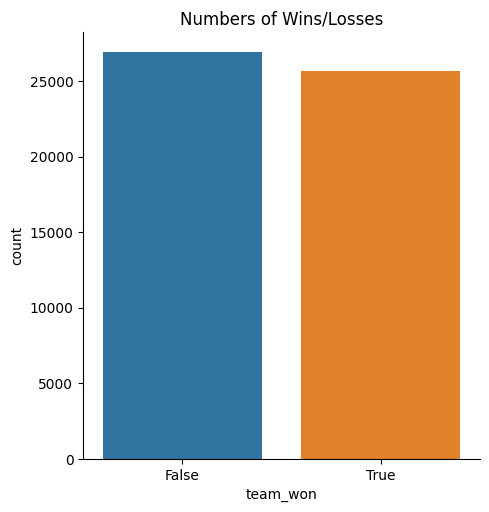

In [21]:
# plot the number of wins and losses
sns.catplot(data = df, x = 'team_won', kind='count')
plt.title("Numbers of Wins/Losses");

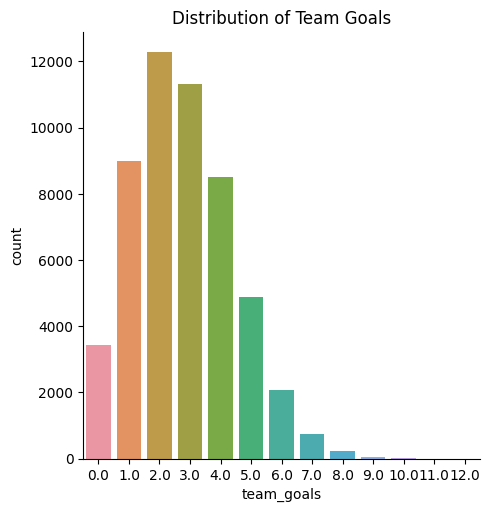

In [22]:
# plot the distribution of team goals
sns.catplot(data = df, x = 'team_goals', kind='count')
plt.title("Distribution of Team Goals");

Text(0.5, 1.0, 'Number of Shots taken versus Goals Scored in Game')

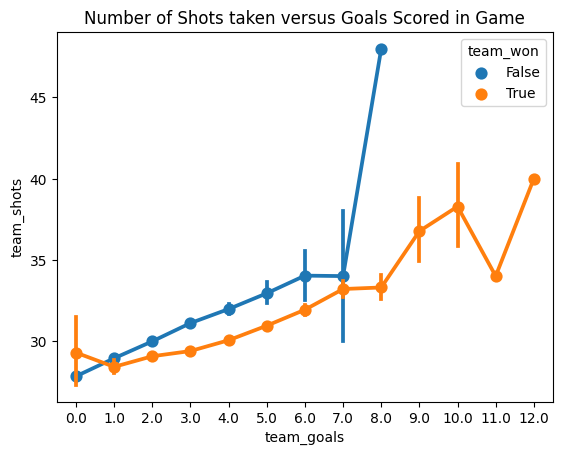

In [23]:
sns.pointplot(data = df, x = 'team_goals', y='team_shots', hue='team_won')
plt.title("Number of Shots taken versus Goals Scored in Game")

In [24]:
def build_model(classifier, params):
    
    """
    
    Builds the pipeline and carries out a grid search to improve the model
    
    Parameters:
        classifier - classifier to be used in model
    
    Returns:
        cv - Classifier object
    
    """
    
    pipeline = Pipeline([
        ('clf', MultiOutputClassifier(classifier)),
    ])
        
    # carry out grid search
    cv = GridSearchCV(pipeline, param_grid=params)
    
    return cv


In [25]:
def train(X,y,model):
  
    """
    
    Creates the split between training and test data
    Fits the model using the training data
    Returns the trained model along with the test datasets
    
    Parameters:
        X - DataFrame of other columns 
        y - Result DataFrame 
        model - the ML model built in the build_model function
        
    Returns:
        model - model trained on the training datasets
        X_test - DataFrame containing test variables
        y_test - DataFrame containing test results
    
    """
    # need to identify type for X 
    X=X.astype('int')
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    model.fit(X_train, y_train)
      
    return model, X_test, y_test

In [26]:
def evaluate_model(model, name, X_test, y_test):

    """
    
    Evaluates the model and produces results for each column in a dataframe
    Results include an f1 score, precision score and a recall score for each
    category in the dataset
    
    Parameters:
        model - the model to be evaluated
        X_test - DataFrame containing test variables
        y_test - DataFrame containing test results
        
    Returns:
        results_df - DataFrame containing results of model testing
    
    """

    y_pred = model.predict(X_test)
    
    model_f1 = f1_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    results_df = pd.DataFrame()
    results_df = results_df.append({'f1 score' : model_f1, 'precision': model_precision, 'recall': model_recall},
                                    ignore_index = True)
    results_df.insert(loc=0,column='Model',value=name)
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test,y_pred))
    
    
    return results_df

In [27]:
X = df.drop(['team_won'], axis=1)
y = df[['team_won']]

classifiers_list = [
    RandomForestClassifier() 
    , KNeighborsClassifier()
    , MLPClassifier()
    , MultinomialNB()
] 

classifiers_name = [
    'Random Forest'
    , 'k-Nearest Neighbors'
    , 'Artificial Neural Network'
    , 'Multinomial Naive Bayes'
]

parameter_list = [
    {
        'clf__estimator__n_estimators' : [10,40]
        }
    , {
        'clf__estimator__n_neighbors': [5]
        }
    , {
        'clf__estimator__max_iter': [10]
        }
    , 
    {
        'clf__estimator__alpha': [0.01]
        }
    ]

In [28]:
# create dataframe to hold overall results for each model
model_res_df = pd.DataFrame()

for name, clf, params in zip(classifiers_name, classifiers_list, parameter_list):
    print('Building model...')
    model = build_model(clf, params) 

    print('Training model with ' + name + ' classifier...')
    model, X_test, y_test = train(X, y, model)  

    print('Evaluating model...')
    results_df = evaluate_model(model, name, X_test, y_test)
    print('Evaluation completed.\n')
    model_res_df = pd.concat([model_res_df,results_df])

print('Process Complete.  Model comparison:')

model_res_df

Building model...
Training model with Random Forest classifier...
Evaluating model...
Confusion Matrix:
[[6163  495]
 [ 677 5803]]
Evaluation completed.

Building model...
Training model with k-Nearest Neighbors classifier...
Evaluating model...
Confusion Matrix:
[[5035 1664]
 [1210 5229]]
Evaluation completed.

Building model...
Training model with Artificial Neural Network classifier...
Evaluating model...
Confusion Matrix:
[[2465 4263]
 [   6 6404]]
Evaluation completed.

Building model...
Training model with Multinomial Naive Bayes classifier...
Evaluating model...
Confusion Matrix:
[[3745 3007]
 [ 437 5949]]
Evaluation completed.

Process Complete.  Model comparison:


,Model,f1 score,precision,recall
0,Random Forest,0.908280,0.921404,0.895525
0,k-Nearest Neighbors,0.784428,0.758596,0.812083
0,Artificial Neural Network,0.750015,0.600356,0.999064
0,Multinomial Naive Bayes,0.775518,0.664247,0.931569


In [29]:
X_refined = X[['team_goals', 'team_shots', 'team_hits', 'team_pim',
       'team_powerPlayOpportunities', 'team_powerPlayGoals', 'team_giveaways',
       'team_takeaways', 'team_blocked', 'team_home', 'team_away',
       'team_start_on_left', 'team_start_on_right', 'team_overtime_required',
       'team_regulation', 'goalie_assists', 'goalie_goals', 'goalie_pim',
       'goalie_shots', 'goalie_saves', 'goalie_powerPlaySaves',
       'goalie_shortHandedSaves', 'goalie_evenSaves',
       'goalie_shortHandedShotsAgainst', 'goalie_evenShotsAgainst',
       'goalie_powerPlayShotsAgainst', 'goalie_goalies_used',
       'goalie_save_percentage', 'goalie_power_play_save_percentage',
       'goalie_even_strength_save_percentage', 'skater_assists',
       'skater_faceOffWins', 'skater_faceoffTaken', 'skater_powerPlayAssists',
       'skater_shortHandedGoals', 'skater_shortHandedAssists']]

# create dataframe to hold overall results for each model
model_res_df = pd.DataFrame()

for name, clf, params in zip(classifiers_name, classifiers_list, parameter_list):
    print('Building model...')
    model = build_model(clf, params) 

    print('Training model with ' + name + ' classifier...')
    model, X_test, y_test = train(X_refined, y, model)  

    print('Evaluating model...')
    results_df = evaluate_model(model, name, X_test, y_test)
    print('Evaluation completed.\n')
    model_res_df = pd.concat([model_res_df,results_df])

print('Process Complete.  Model comparison:')

model_res_df

Building model...
Training model with Random Forest classifier...
Evaluating model...
Confusion Matrix:
[[6114  701]
 [ 791 5532]]
Evaluation completed.

Building model...
Training model with k-Nearest Neighbors classifier...
Evaluating model...
Confusion Matrix:
[[5134 1500]
 [1945 4559]]
Evaluation completed.

Building model...
Training model with Artificial Neural Network classifier...
Evaluating model...
Confusion Matrix:
[[6585  110]
 [ 737 5706]]
Evaluation completed.

Building model...
Training model with Multinomial Naive Bayes classifier...
Evaluating model...
Confusion Matrix:
[[5432 1362]
 [1274 5070]]
Evaluation completed.

Process Complete.  Model comparison:


,Model,f1 score,precision,recall
0,Random Forest,0.881172,0.887534,0.874901
0,k-Nearest Neighbors,0.725782,0.752434,0.700953
0,Artificial Neural Network,0.930908,0.981087,0.885612
0,Multinomial Naive Bayes,0.793676,0.788246,0.799180


In [30]:
# Assuming 'X' is your feature matrix and 'y' is your target variable (win/lose)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)


Accuracy: 0.9587099229378746
Confusion Matrix:
 [[5226  143]
 [ 291 4851]]
Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.97      0.96      5369
        True       0.97      0.94      0.96      5142

    accuracy                           0.96     10511
   macro avg       0.96      0.96      0.96     10511
weighted avg       0.96      0.96      0.96     10511



In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import warnings
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from keras.optimizers import RMSprop
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

df = pd.read_csv("CleanHockeyData.csv")
df = df.round(5)
df = df.drop(['Unnamed: 0'], axis=1)
df = df.set_index('Name')

2023-12-11 09:35:08.343962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
data = df.loc[:,['pctCap','TOI','pyTOI','Goals60','pyGoals60','Assists60','pyAssists60','PlusMinus60',
                 'pyPlusMinus60','PenaltyMinutes60','pyPenaltyMinutes60','EvenStrGoals60','pyEvenStrGoals60',
                 'ppGoals60','pyppGoals60','shGoals60','pyshGoals60','GameWinningGoals60','pyGameWinningGoals60',
                 'Shots60','pyShots60','Country.Austria','Country.Canada','Country.Czech Republic',
                 'Country.Denmark','Country.Estonia','Country.Finland','Country.France','Country.Germany',
                 'Country.Latvia','Country.Norway','Country.Russia','Country.Slovakia','Country.Slovenia',
                 'Country.Sweden','Country.Switzerland','Country.United Kingdom','Country.United States',
                 'Team.ANA','Team.ARI','Team.BOS','Team.BUF','Team.CAR','Team.CBJ','Team.CGY','Team.CHI','Team.COL',
                 'Team.DAL','Team.DET','Team.EDM','Team.FLA','Team.LAK','Team.MIN','Team.MTL','Team.NJD','Team.NSH',
                 'Team.NYI','Team.NYR','Team.OTT','Team.PHI','Team.PIT','Team.SJS','Team.STL','Team.TBL','Team.TOR',
                 'Team.VAN','Team.VGK','Team.WPG','Team.WSH','Handed.R','Position.C','Position.R']]


In [33]:
# duplicating the dataset
dataset = data

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('pctCap')
test_labels = test_dataset.pop('pctCap')

train_dataset = np.array(train_dataset)
test_dataset = np.array(test_dataset)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [34]:
def build_model():
  model = keras.Sequential([
    layers.Dense(42, activation='linear', kernel_initializer='VarianceScaling', 
                 input_shape=[71]),
    layers.Dense(59, activation='linear'),  
    layers.Dense(1)
  ])
  
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
  return model

model = build_model()

In [35]:
trainnn = model.fit(train_dataset, train_labels, epochs=1000, 
                    validation_split = 0.2, batch_size=1, verbose=1)

Epoch 1/1000
195/195 [==============================] - 1s 2ms/step - loss: 1746.1261 - mae: 12.2106 - mse: 1746.1261 - val_loss: 0.0925 - val_mae: 0.2516 - val_mse: 0.0925
Epoch 2/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.1666 - mae: 0.3195 - mse: 0.1666 - val_loss: 0.0950 - val_mae: 0.2547 - val_mse: 0.0950
Epoch 3/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.6371 - mae: 0.6028 - mse: 0.6371 - val_loss: 3.3834 - val_mae: 1.7626 - val_mse: 3.3834
Epoch 4/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.6013 - mae: 0.5740 - mse: 0.6013 - val_loss: 0.2835 - val_mae: 0.4600 - val_mse: 0.2835
Epoch 5/1000
195/195 [==============================] - 0s 1ms/step - loss: 0.7949 - mae: 0.6572 - mse: 0.7949 - val_loss: 3.2443 - val_mae: 1.7158 - val_mse: 3.2443
Epoch 6/1000
195/195 [==============================] - 0s 1ms/step - loss: 8.4820 - mae: 1.9686 - mse: 8.4820 - val_loss: 47.8738 - val_mae: 6.6994 - val_mse: 47.

195/195 [==============================] - 0s 2ms/step - loss: 11.9520 - mae: 2.5743 - mse: 11.9520 - val_loss: 6.0612 - val_mae: 1.9359 - val_mse: 6.0612
Epoch 50/1000
195/195 [==============================] - 0s 2ms/step - loss: 42.0767 - mae: 4.2005 - mse: 42.0767 - val_loss: 1.0163 - val_mae: 0.9029 - val_mse: 1.0163
Epoch 51/1000
195/195 [==============================] - 0s 2ms/step - loss: 2.3722 - mae: 1.1220 - mse: 2.3722 - val_loss: 0.2020 - val_mae: 0.4096 - val_mse: 0.2020
Epoch 52/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1943 - mse: 0.0697 - val_loss: 0.1032 - val_mae: 0.2895 - val_mse: 0.1032
Epoch 53/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.1224 - mae: 0.2786 - mse: 0.1224 - val_loss: 0.0361 - val_mae: 0.1400 - val_mse: 0.0361
Epoch 54/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.1092 - mae: 0.2606 - mse: 0.1092 - val_loss: 0.0254 - val_mae: 0.1364 - val_mse: 0.0254
Epoch 55

195/195 [==============================] - 2s 9ms/step - loss: 0.0091 - mae: 0.0743 - mse: 0.0091 - val_loss: 0.0019 - val_mae: 0.0348 - val_mse: 0.0019
Epoch 99/1000
195/195 [==============================] - 1s 7ms/step - loss: 0.0063 - mae: 0.0615 - mse: 0.0063 - val_loss: 0.0018 - val_mae: 0.0332 - val_mse: 0.0018
Epoch 100/1000
195/195 [==============================] - 2s 9ms/step - loss: 0.0109 - mae: 0.0820 - mse: 0.0109 - val_loss: 0.0030 - val_mae: 0.0426 - val_mse: 0.0030
Epoch 101/1000
195/195 [==============================] - 2s 8ms/step - loss: 0.0351 - mae: 0.1319 - mse: 0.0351 - val_loss: 0.0115 - val_mae: 0.0984 - val_mse: 0.0115
Epoch 102/1000
195/195 [==============================] - 1s 5ms/step - loss: 0.0130 - mae: 0.0840 - mse: 0.0130 - val_loss: 0.0047 - val_mae: 0.0500 - val_mse: 0.0047
Epoch 103/1000
195/195 [==============================] - 1s 5ms/step - loss: 0.0116 - mae: 0.0814 - mse: 0.0116 - val_loss: 0.0106 - val_mae: 0.0782 - val_mse: 0.0106
Epoch 10

195/195 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0258 - val_mse: 0.0012
Epoch 147/1000
195/195 [==============================] - 0s 2ms/step - loss: 9.4348e-04 - mae: 0.0244 - mse: 9.4348e-04 - val_loss: 0.0011 - val_mae: 0.0281 - val_mse: 0.0011
Epoch 148/1000
195/195 [==============================] - 1s 3ms/step - loss: 0.0014 - mae: 0.0283 - mse: 0.0014 - val_loss: 8.1249e-04 - val_mae: 0.0231 - val_mse: 8.1249e-04
Epoch 149/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0304 - mse: 0.0016 - val_loss: 0.0017 - val_mae: 0.0358 - val_mse: 0.0017
Epoch 150/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0336 - mse: 0.0017 - val_loss: 0.0021 - val_mae: 0.0371 - val_mse: 0.0021
Epoch 151/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0346 - mse: 0.0020 - val_loss: 0.0018 - val_mae: 0.0320 - val_mse

195/195 [==============================] - 0s 1ms/step - loss: 6.6689e-04 - mae: 0.0195 - mse: 6.6689e-04 - val_loss: 5.6603e-04 - val_mae: 0.0175 - val_mse: 5.6603e-04
Epoch 193/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.0214e-04 - mae: 0.0204 - mse: 7.0214e-04 - val_loss: 0.0011 - val_mae: 0.0264 - val_mse: 0.0011
Epoch 194/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.9034e-04 - mae: 0.0223 - mse: 7.9034e-04 - val_loss: 4.4969e-04 - val_mae: 0.0163 - val_mse: 4.4969e-04
Epoch 195/1000
195/195 [==============================] - 0s 1ms/step - loss: 6.6064e-04 - mae: 0.0190 - mse: 6.6064e-04 - val_loss: 5.6259e-04 - val_mae: 0.0188 - val_mse: 5.6259e-04
Epoch 196/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.5088e-04 - mae: 0.0222 - mse: 7.5088e-04 - val_loss: 8.7627e-04 - val_mae: 0.0224 - val_mse: 8.7627e-04
Epoch 197/1000
195/195 [==============================] - 0s 2ms/step - loss: 8.5598e-04 - mae: 0.0229 

195/195 [==============================] - 0s 2ms/step - loss: 6.6932e-04 - mae: 0.0216 - mse: 6.6932e-04 - val_loss: 5.3170e-04 - val_mae: 0.0189 - val_mse: 5.3170e-04
Epoch 239/1000
195/195 [==============================] - 0s 2ms/step - loss: 8.3074e-04 - mae: 0.0224 - mse: 8.3074e-04 - val_loss: 7.4799e-04 - val_mae: 0.0229 - val_mse: 7.4799e-04
Epoch 240/1000
195/195 [==============================] - 0s 2ms/step - loss: 6.6071e-04 - mae: 0.0205 - mse: 6.6071e-04 - val_loss: 0.0032 - val_mae: 0.0492 - val_mse: 0.0032
Epoch 241/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0010 - mae: 0.0247 - mse: 0.0010 - val_loss: 0.0015 - val_mae: 0.0307 - val_mse: 0.0015
Epoch 242/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0017 - mae: 0.0316 - mse: 0.0017 - val_loss: 9.1017e-04 - val_mae: 0.0229 - val_mse: 9.1017e-04
Epoch 243/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0271 - mse: 0.0012 - val_loss: 5.

Epoch 284/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0263 - mse: 0.0012 - val_loss: 0.0010 - val_mae: 0.0240 - val_mse: 0.0010
Epoch 285/1000
195/195 [==============================] - 0s 1ms/step - loss: 7.3334e-04 - mae: 0.0215 - mse: 7.3334e-04 - val_loss: 8.5322e-04 - val_mae: 0.0251 - val_mse: 8.5322e-04
Epoch 286/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0352 - mse: 0.0024 - val_loss: 0.0290 - val_mae: 0.1627 - val_mse: 0.0290
Epoch 287/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0326 - mse: 0.0027 - val_loss: 5.1066e-04 - val_mae: 0.0186 - val_mse: 5.1066e-04
Epoch 288/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0013 - mae: 0.0288 - mse: 0.0013 - val_loss: 6.8960e-04 - val_mae: 0.0192 - val_mse: 6.8960e-04
Epoch 289/1000
195/195 [==============================] - 0s 2ms/step - loss: 8.8937e-04 - mae: 0.0233 - mse: 8.8937e-04 - val_l

Epoch 330/1000
195/195 [==============================] - 0s 1ms/step - loss: 7.8381e-04 - mae: 0.0213 - mse: 7.8381e-04 - val_loss: 0.0011 - val_mae: 0.0284 - val_mse: 0.0011
Epoch 331/1000
195/195 [==============================] - 0s 1ms/step - loss: 9.8472e-04 - mae: 0.0248 - mse: 9.8472e-04 - val_loss: 5.1101e-04 - val_mae: 0.0177 - val_mse: 5.1101e-04
Epoch 332/1000
195/195 [==============================] - 0s 1ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 6.4675e-04 - val_mae: 0.0218 - val_mse: 6.4675e-04
Epoch 333/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.2418e-04 - mae: 0.0213 - mse: 7.2418e-04 - val_loss: 6.1352e-04 - val_mae: 0.0209 - val_mse: 6.1352e-04
Epoch 334/1000
195/195 [==============================] - 0s 1ms/step - loss: 7.0945e-04 - mae: 0.0207 - mse: 7.0945e-04 - val_loss: 5.1765e-04 - val_mae: 0.0176 - val_mse: 5.1765e-04
Epoch 335/1000
195/195 [==============================] - 0s 1ms/step - loss: 0.0017 - mae: 0.03

Epoch 376/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.3351e-04 - mae: 0.0184 - mse: 5.3351e-04 - val_loss: 7.4582e-04 - val_mae: 0.0233 - val_mse: 7.4582e-04
Epoch 377/1000
195/195 [==============================] - 0s 1ms/step - loss: 9.4485e-04 - mae: 0.0242 - mse: 9.4485e-04 - val_loss: 0.0130 - val_mae: 0.1089 - val_mse: 0.0130
Epoch 378/1000
195/195 [==============================] - 0s 1ms/step - loss: 0.0016 - mae: 0.0298 - mse: 0.0016 - val_loss: 4.7993e-04 - val_mae: 0.0169 - val_mse: 4.7993e-04
Epoch 379/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.5756e-04 - mae: 0.0184 - mse: 5.5756e-04 - val_loss: 5.0201e-04 - val_mae: 0.0168 - val_mse: 5.0201e-04
Epoch 380/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.4193e-04 - mae: 0.0183 - mse: 5.4193e-04 - val_loss: 4.6042e-04 - val_mae: 0.0170 - val_mse: 4.6042e-04
Epoch 381/1000
195/195 [==============================] - 0s 1ms/step - loss: 6.1018e-04 - mae: 

195/195 [==============================] - 0s 2ms/step - loss: 4.6629e-04 - mae: 0.0164 - mse: 4.6629e-04 - val_loss: 8.6627e-04 - val_mae: 0.0218 - val_mse: 8.6627e-04
Epoch 422/1000
195/195 [==============================] - 0s 1ms/step - loss: 6.2696e-04 - mae: 0.0186 - mse: 6.2696e-04 - val_loss: 8.3579e-04 - val_mae: 0.0247 - val_mse: 8.3579e-04
Epoch 423/1000
195/195 [==============================] - 0s 2ms/step - loss: 6.3118e-04 - mae: 0.0200 - mse: 6.3118e-04 - val_loss: 5.5310e-04 - val_mae: 0.0168 - val_mse: 5.5310e-04
Epoch 424/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.2916e-04 - mae: 0.0175 - mse: 5.2916e-04 - val_loss: 5.9267e-04 - val_mae: 0.0203 - val_mse: 5.9267e-04
Epoch 425/1000
195/195 [==============================] - 0s 1ms/step - loss: 4.9389e-04 - mae: 0.0170 - mse: 4.9389e-04 - val_loss: 0.0012 - val_mae: 0.0284 - val_mse: 0.0012
Epoch 426/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.9852e-04 - mae: 0.0182 

Epoch 466/1000
195/195 [==============================] - 0s 1ms/step - loss: 6.0502e-04 - mae: 0.0184 - mse: 6.0502e-04 - val_loss: 4.3800e-04 - val_mae: 0.0158 - val_mse: 4.3800e-04
Epoch 467/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.4288e-04 - mae: 0.0176 - mse: 5.4288e-04 - val_loss: 4.4886e-04 - val_mae: 0.0157 - val_mse: 4.4886e-04
Epoch 468/1000
195/195 [==============================] - 0s 1ms/step - loss: 4.6901e-04 - mae: 0.0170 - mse: 4.6901e-04 - val_loss: 4.2066e-04 - val_mae: 0.0158 - val_mse: 4.2066e-04
Epoch 469/1000
195/195 [==============================] - 0s 1ms/step - loss: 4.4618e-04 - mae: 0.0157 - mse: 4.4618e-04 - val_loss: 4.7200e-04 - val_mae: 0.0162 - val_mse: 4.7200e-04
Epoch 470/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.4110e-04 - mae: 0.0178 - mse: 5.4110e-04 - val_loss: 4.5256e-04 - val_mae: 0.0157 - val_mse: 4.5256e-04
Epoch 471/1000
195/195 [==============================] - 0s 1ms/step - loss: 4.

Epoch 511/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.0376e-04 - mae: 0.0203 - mse: 7.0376e-04 - val_loss: 4.2315e-04 - val_mae: 0.0157 - val_mse: 4.2315e-04
Epoch 512/1000
195/195 [==============================] - 0s 1ms/step - loss: 5.1595e-04 - mae: 0.0177 - mse: 5.1595e-04 - val_loss: 6.0689e-04 - val_mae: 0.0205 - val_mse: 6.0689e-04
Epoch 513/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.8824e-04 - mae: 0.0172 - mse: 4.8824e-04 - val_loss: 4.3964e-04 - val_mae: 0.0159 - val_mse: 4.3964e-04
Epoch 514/1000
195/195 [==============================] - 0s 1ms/step - loss: 4.6485e-04 - mae: 0.0164 - mse: 4.6485e-04 - val_loss: 5.1166e-04 - val_mae: 0.0166 - val_mse: 5.1166e-04
Epoch 515/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.9985e-04 - mae: 0.0174 - mse: 4.9985e-04 - val_loss: 4.4409e-04 - val_mae: 0.0169 - val_mse: 4.4409e-04
Epoch 516/1000
195/195 [==============================] - 0s 1ms/step - loss: 8.

Epoch 556/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.3905e-04 - mae: 0.0161 - mse: 4.3905e-04 - val_loss: 4.6349e-04 - val_mae: 0.0163 - val_mse: 4.6349e-04
Epoch 557/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.4591e-04 - mae: 0.0165 - mse: 4.4591e-04 - val_loss: 4.5218e-04 - val_mae: 0.0170 - val_mse: 4.5218e-04
Epoch 558/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.8632e-04 - mae: 0.0170 - mse: 4.8632e-04 - val_loss: 6.8622e-04 - val_mae: 0.0223 - val_mse: 6.8622e-04
Epoch 559/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.0388e-04 - mae: 0.0174 - mse: 5.0388e-04 - val_loss: 5.5849e-04 - val_mae: 0.0173 - val_mse: 5.5849e-04
Epoch 560/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.4578e-04 - mae: 0.0154 - mse: 4.4578e-04 - val_loss: 4.4726e-04 - val_mae: 0.0159 - val_mse: 4.4726e-04
Epoch 561/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.

Epoch 601/1000
195/195 [==============================] - 0s 2ms/step - loss: 6.4064e-04 - mae: 0.0191 - mse: 6.4064e-04 - val_loss: 4.3559e-04 - val_mae: 0.0164 - val_mse: 4.3559e-04
Epoch 602/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.9932e-04 - mae: 0.0174 - mse: 4.9932e-04 - val_loss: 7.2356e-04 - val_mae: 0.0226 - val_mse: 7.2356e-04
Epoch 603/1000
195/195 [==============================] - 0s 2ms/step - loss: 8.1646e-04 - mae: 0.0217 - mse: 8.1646e-04 - val_loss: 7.2451e-04 - val_mae: 0.0230 - val_mse: 7.2451e-04
Epoch 604/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.9743e-04 - mae: 0.0173 - mse: 4.9743e-04 - val_loss: 4.6474e-04 - val_mae: 0.0172 - val_mse: 4.6474e-04
Epoch 605/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.4663e-04 - mae: 0.0188 - mse: 5.4663e-04 - val_loss: 0.0010 - val_mae: 0.0273 - val_mse: 0.0010
Epoch 606/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.1645e-04

Epoch 646/1000
195/195 [==============================] - 0s 2ms/step - loss: 6.8089e-04 - mae: 0.0202 - mse: 6.8089e-04 - val_loss: 4.8129e-04 - val_mae: 0.0166 - val_mse: 4.8129e-04
Epoch 647/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.9354e-04 - mae: 0.0174 - mse: 4.9354e-04 - val_loss: 4.5585e-04 - val_mae: 0.0169 - val_mse: 4.5585e-04
Epoch 648/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.3398e-04 - mae: 0.0160 - mse: 4.3398e-04 - val_loss: 7.3353e-04 - val_mae: 0.0226 - val_mse: 7.3353e-04
Epoch 649/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.1617e-04 - mae: 0.0157 - mse: 4.1617e-04 - val_loss: 4.7431e-04 - val_mae: 0.0170 - val_mse: 4.7431e-04
Epoch 650/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.0461e-04 - mae: 0.0155 - mse: 4.0461e-04 - val_loss: 4.4530e-04 - val_mae: 0.0166 - val_mse: 4.4530e-04
Epoch 651/1000
195/195 [==============================] - 1s 3ms/step - loss: 4.

Epoch 691/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.5917e-04 - mae: 0.0162 - mse: 4.5917e-04 - val_loss: 4.4529e-04 - val_mae: 0.0167 - val_mse: 4.4529e-04
Epoch 692/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.4513e-04 - mae: 0.0161 - mse: 4.4513e-04 - val_loss: 5.8258e-04 - val_mae: 0.0191 - val_mse: 5.8258e-04
Epoch 693/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.4269e-04 - mae: 0.0158 - mse: 4.4269e-04 - val_loss: 9.6909e-04 - val_mae: 0.0268 - val_mse: 9.6909e-04
Epoch 694/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0126 - mae: 0.0584 - mse: 0.0126 - val_loss: 0.0024 - val_mae: 0.0365 - val_mse: 0.0024
Epoch 695/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.0910e-04 - mae: 0.0175 - mse: 5.0910e-04 - val_loss: 4.9114e-04 - val_mae: 0.0176 - val_mse: 4.9114e-04
Epoch 696/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.7383e-04 - mae: 

Epoch 736/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.1330e-04 - mae: 0.0157 - mse: 4.1330e-04 - val_loss: 5.1088e-04 - val_mae: 0.0182 - val_mse: 5.1088e-04
Epoch 737/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.1021e-04 - mae: 0.0160 - mse: 4.1021e-04 - val_loss: 4.8042e-04 - val_mae: 0.0175 - val_mse: 4.8042e-04
Epoch 738/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.0019e-04 - mae: 0.0151 - mse: 4.0019e-04 - val_loss: 5.1829e-04 - val_mae: 0.0176 - val_mse: 5.1829e-04
Epoch 739/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.1677e-04 - mae: 0.0157 - mse: 4.1677e-04 - val_loss: 8.1525e-04 - val_mae: 0.0233 - val_mse: 8.1525e-04
Epoch 740/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.3202e-04 - mae: 0.0178 - mse: 5.3202e-04 - val_loss: 5.1757e-04 - val_mae: 0.0180 - val_mse: 5.1757e-04
Epoch 741/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.

Epoch 781/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.8313e-04 - mae: 0.0169 - mse: 4.8313e-04 - val_loss: 5.5172e-04 - val_mae: 0.0182 - val_mse: 5.5172e-04
Epoch 782/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0321 - mse: 0.0037 - val_loss: 0.0016 - val_mae: 0.0344 - val_mse: 0.0016
Epoch 783/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0250 - mse: 0.0012 - val_loss: 8.9352e-04 - val_mae: 0.0251 - val_mse: 8.9352e-04
Epoch 784/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.6694e-04 - mae: 0.0169 - mse: 4.6694e-04 - val_loss: 5.6458e-04 - val_mae: 0.0187 - val_mse: 5.6458e-04
Epoch 785/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.3473e-04 - mae: 0.0164 - mse: 4.3473e-04 - val_loss: 4.3754e-04 - val_mae: 0.0163 - val_mse: 4.3754e-04
Epoch 786/1000
195/195 [==============================] - 0s 2ms/step - loss: 3.8062e-04 - mae: 0.0154 -

Epoch 826/1000
195/195 [==============================] - 0s 2ms/step - loss: 3.9847e-04 - mae: 0.0154 - mse: 3.9847e-04 - val_loss: 4.5281e-04 - val_mae: 0.0167 - val_mse: 4.5281e-04
Epoch 827/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.8383e-04 - mae: 0.0171 - mse: 4.8383e-04 - val_loss: 0.0018 - val_mae: 0.0362 - val_mse: 0.0018
Epoch 828/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.2608e-04 - mae: 0.0162 - mse: 4.2608e-04 - val_loss: 4.4556e-04 - val_mae: 0.0166 - val_mse: 4.4556e-04
Epoch 829/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.0431e-04 - mae: 0.0156 - mse: 4.0431e-04 - val_loss: 5.1644e-04 - val_mae: 0.0179 - val_mse: 5.1644e-04
Epoch 830/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.5083e-04 - mae: 0.0163 - mse: 4.5083e-04 - val_loss: 4.8727e-04 - val_mae: 0.0177 - val_mse: 4.8727e-04
Epoch 831/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.1559e-04

195/195 [==============================] - 0s 2ms/step - loss: 3.6713e-04 - mae: 0.0147 - mse: 3.6713e-04 - val_loss: 5.1816e-04 - val_mae: 0.0179 - val_mse: 5.1816e-04
Epoch 871/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0082 - mae: 0.0565 - mse: 0.0082 - val_loss: 0.0036 - val_mae: 0.0538 - val_mse: 0.0036
Epoch 872/1000
195/195 [==============================] - 0s 2ms/step - loss: 7.7280e-04 - mae: 0.0207 - mse: 7.7280e-04 - val_loss: 6.9594e-04 - val_mae: 0.0227 - val_mse: 6.9594e-04
Epoch 873/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.7175e-04 - mae: 0.0182 - mse: 5.7175e-04 - val_loss: 7.8464e-04 - val_mae: 0.0240 - val_mse: 7.8464e-04
Epoch 874/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.7851e-04 - mae: 0.0169 - mse: 4.7851e-04 - val_loss: 9.6467e-04 - val_mae: 0.0263 - val_mse: 9.6467e-04
Epoch 875/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.3131e-04 - mae: 0.0162 - mse: 4

Epoch 915/1000
195/195 [==============================] - 0s 2ms/step - loss: 3.5450e-04 - mae: 0.0144 - mse: 3.5450e-04 - val_loss: 4.6259e-04 - val_mae: 0.0166 - val_mse: 4.6259e-04
Epoch 916/1000
195/195 [==============================] - 0s 2ms/step - loss: 3.9478e-04 - mae: 0.0153 - mse: 3.9478e-04 - val_loss: 5.8050e-04 - val_mae: 0.0192 - val_mse: 5.8050e-04
Epoch 917/1000
195/195 [==============================] - 0s 2ms/step - loss: 3.7571e-04 - mae: 0.0148 - mse: 3.7571e-04 - val_loss: 4.5118e-04 - val_mae: 0.0166 - val_mse: 4.5118e-04
Epoch 918/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.5113e-04 - mae: 0.0165 - mse: 4.5113e-04 - val_loss: 4.5412e-04 - val_mae: 0.0168 - val_mse: 4.5412e-04
Epoch 919/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.9569e-04 - mae: 0.0173 - mse: 4.9569e-04 - val_loss: 4.7450e-04 - val_mae: 0.0172 - val_mse: 4.7450e-04
Epoch 920/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.

Epoch 960/1000
195/195 [==============================] - 0s 2ms/step - loss: 0.0068 - mae: 0.0510 - mse: 0.0068 - val_loss: 0.0015 - val_mae: 0.0340 - val_mse: 0.0015
Epoch 961/1000
195/195 [==============================] - 0s 2ms/step - loss: 5.6459e-04 - mae: 0.0188 - mse: 5.6459e-04 - val_loss: 5.5499e-04 - val_mae: 0.0176 - val_mse: 5.5499e-04
Epoch 962/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.4048e-04 - mae: 0.0167 - mse: 4.4048e-04 - val_loss: 0.0011 - val_mae: 0.0263 - val_mse: 0.0011
Epoch 963/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.7582e-04 - mae: 0.0165 - mse: 4.7582e-04 - val_loss: 5.6551e-04 - val_mae: 0.0192 - val_mse: 5.6551e-04
Epoch 964/1000
195/195 [==============================] - 0s 2ms/step - loss: 4.8681e-04 - mae: 0.0171 - mse: 4.8681e-04 - val_loss: 4.7577e-04 - val_mae: 0.0168 - val_mse: 4.7577e-04
Epoch 965/1000
195/195 [==============================] - 0s 2ms/step - loss: 3.8841e-04 - mae: 0.0151 -

In [36]:
allData = data.iloc[:,1:]
onlypctCap = data.iloc[:,[0]]
preds = model.predict(allData).flatten()
onlypctCap['Preds'] = list(preds)
allData = pd.DataFrame(allData)
dfNN = pd.merge(allData,onlypctCap, left_index=True, right_index=True)

10/10 [==============================] - 0s 2ms/step


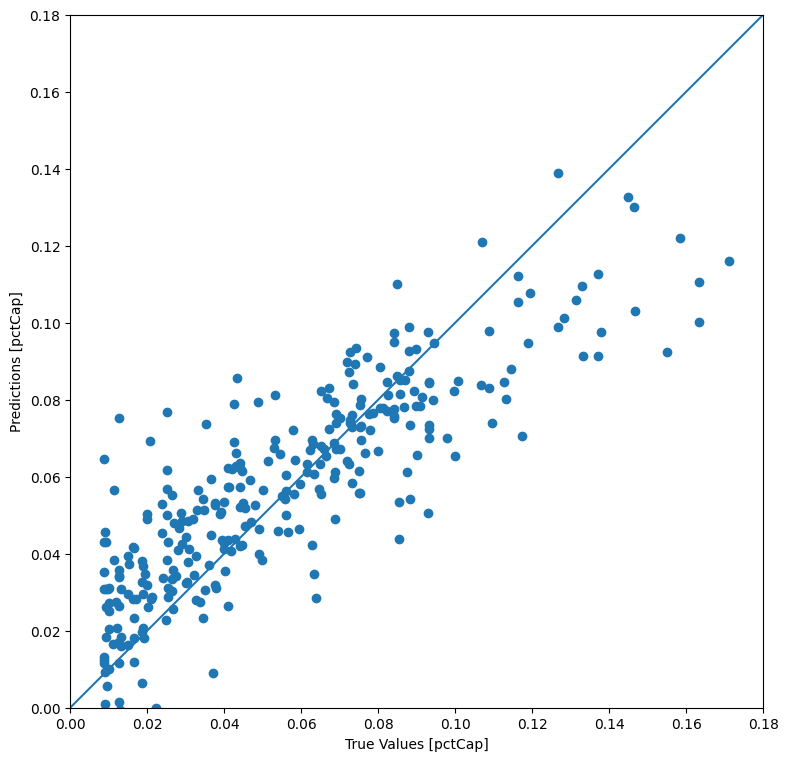

In [37]:
plt.figure(figsize=(9,9))
a = plt.axes(aspect='equal')
plt.scatter(dfNN['pctCap'], dfNN['Preds'])
plt.xlabel('True Values [pctCap]')
plt.ylabel('Predictions [pctCap]')
lims = [0, .18]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [38]:
print('Mean Absolute Error:', metrics.mean_absolute_error(dfNN['pctCap'], dfNN['Preds']))  
print('Mean Squared Error:', metrics.mean_squared_error(dfNN['pctCap'], dfNN['Preds']))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(dfNN['pctCap'], dfNN['Preds'])))

Mean Absolute Error: 0.014716895568864267
Mean Squared Error: 0.00037653475964982995
Root Mean Squared Error: 0.019404503591945607


In [40]:
cor = dataset.corr()
cor_target = abs(cor["pctCap"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

pctCap         1.000000
TOI            0.629342
pyTOI          0.574813
Goals60        0.511954
Assists60      0.651576
pyAssists60    0.558081
ppGoals60      0.551564
pyppGoals60    0.550995
Name: pctCap, dtype: float64

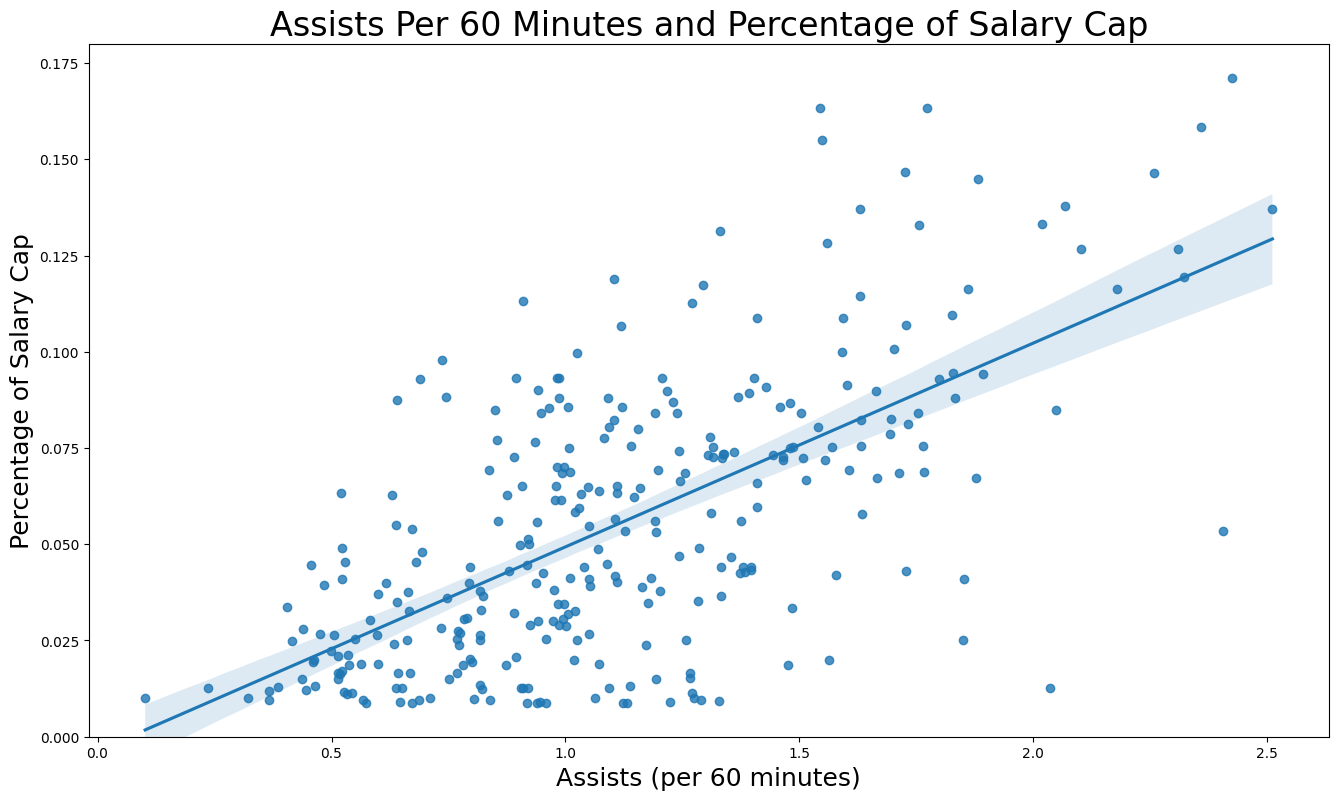

In [41]:
small = df.loc[:,['pctCap','TOI','pyTOI','Goals60','Assists60',
                    'pyAssists60','ppGoals60', 'pyppGoals60']]

fig = plt.figure(figsize=(16,9))
sns.regplot(x=small['Assists60'],y=small['pctCap'])
plt.title('Assists Per 60 Minutes and Percentage of Salary Cap', size=24)
plt.xlabel('Assists (per 60 minutes)', size=18)
plt.ylabel('Percentage of Salary Cap', size=18)
plt.ylim(bottom=0);

In [42]:
X = small['Assists60'].values.reshape(-1,1)
y = small['pctCap'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
check = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
check

,Actual,Predicted
0,0.07329,0.063543
1,0.07667,0.043621
2,0.01667,0.021036
3,0.05507,0.027640
4,0.09283,0.090091
...,...,...
56,0.08833,0.033447
57,0.16330,0.088742
58,0.07534,0.073293
59,0.04489,0.051913


In [43]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.023563290128380265
Mean Squared Error: 0.0009712731127286353
Root Mean Squared Error: 0.031165254895935558


In [44]:
X = small[['TOI','pyTOI','Goals60','Assists60','pyAssists60','ppGoals60', 'pyppGoals60']]

y = small['pctCap'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

regressor = LinearRegression()  
regressor.fit(X_train, y_train);

In [45]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
TOI,0.000029
pyTOI,0.000013
Goals60,0.021359
Assists60,0.026989
pyAssists60,0.011224
ppGoals60,-0.003888
pyppGoals60,0.020195


In [46]:
y_pred = regressor.predict(X_test)
dfPred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfPred.head()

,Actual,Predicted
0,0.07329,0.074415
1,0.07667,0.062619
2,0.01667,0.005122
3,0.05507,0.042783
4,0.09283,0.097590


In [47]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.014824140704958216
Mean Squared Error: 0.00039168816014867075
Root Mean Squared Error: 0.019791113160928336
